## Import data

In [66]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

df = pd.read_csv("data3.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values
print(df.head())  # 5 first lines

emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']

(9369, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9369 entries, 0 to 9368
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email       9369 non-null   object
 1   EMG1        9369 non-null   int64 
 2   EMG2        9369 non-null   int64 
 3   EMG3        9369 non-null   int64 
 4   EMG4        9369 non-null   int64 
 5   EMG5        9369 non-null   int64 
 6   EMG6        9369 non-null   int64 
 7   EMG7        9369 non-null   int64 
 8   EMG8        9369 non-null   int64 
 9   Framecount  9369 non-null   int64 
 10  gesture     9369 non-null   object
 11  SessionID   9369 non-null   object
 12  Timestamp   9369 non-null   object
dtypes: int64(9), object(4)
memory usage: 951.7+ KB
None
       Email  EMG1  EMG2  EMG3  EMG4  EMG5  EMG6  EMG7  EMG8  Framecount  \
0  anonymous   -22   -11   -25   -59    44    29   -39    -2           2   
1  anonymous     5     8    18   104    21    40    92     8           2 

## Clean data
### Manage missing data

In [67]:
df = df.drop_duplicates()  # remove duplicate rows


# remove rows with missing values
df = df.dropna()

# Or fill missing numeric values with column mean
for col in emg_cols:
    df[col] = df[col].fillna(df[col].mean())


### Prepare data

In [68]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # pyright: ignore[reportMissingModuleSource]


# # Detect outliers using Inter Quartile Range (IQR)
# for col in emg_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1

#     df = df[~((df[col] < (Q1 - 4 * IQR)) | (df[col] > (Q3 + 4 * IQR)))]

# Standardization
scaler = StandardScaler()
standard_data = scaler.fit_transform(df[emg_cols])

print("Standardized EMG columns:")
print(standard_data[:5])

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())

Standardized EMG columns:
[[-1.29941199 -1.96612318 -1.1580521  -2.12578652  1.82674255  1.15022371
  -2.04132836 -0.06572974]
 [ 0.36141794  1.7315045   0.92155428  3.90224159  0.89164578  1.57562602
   4.83137263  0.5156183 ]
 [ 0.17688128 -1.18767524 -1.49659267 -3.27222132 -0.40935842 -1.63422776
   4.2542756  -0.70521259]
 [-0.56126536 -2.54995913  0.58301371  2.23806205 -1.99495729 -0.93811489
  -3.45783926 -0.35640376]
 [-0.3767287  -0.40922731 -2.60894026 -1.75596885  1.17624045  1.61429895
  -4.40217985  0.10867467]]

Encoded labels:
      label        gesture
0         2     wrist_back
1804      0           fist
4017      1          pinch
6927      3  wrist_forward


### Split data

In [69]:
from sklearn.model_selection import train_test_split

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
X = standard_data
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Baseline model
### Search best hyperparameter

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define model
search_model = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    "max_depth": [2, 4, 6, 8, 10, None],
    "criterion": ["gini", "entropy"]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(search_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best validation accuracy:", grid_search.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': None}
Best validation accuracy: 0.6976214396011237


### Train model

In [71]:
# 4. Train a simple Decision Tree
model = DecisionTreeClassifier(random_state=42, criterion=grid_search.best_params_["criterion"], max_depth=grid_search.best_params_["max_depth"])
model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Evaluation

Validation accuracy: 0.701779359430605
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       336
           1       0.58      0.64      0.61       420
           2       0.72      0.68      0.70       275
           3       0.92      0.93      0.92       374

    accuracy                           0.70      1405
   macro avg       0.70      0.70      0.70      1405
weighted avg       0.70      0.70      0.70      1405

Cross-validation scores: [0.60142349 0.69395018 0.65480427 0.6405694  0.72241993]
Mean accuracy: 0.6626334519572954


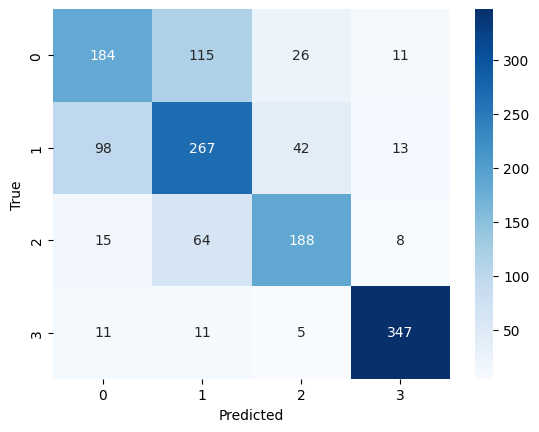

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


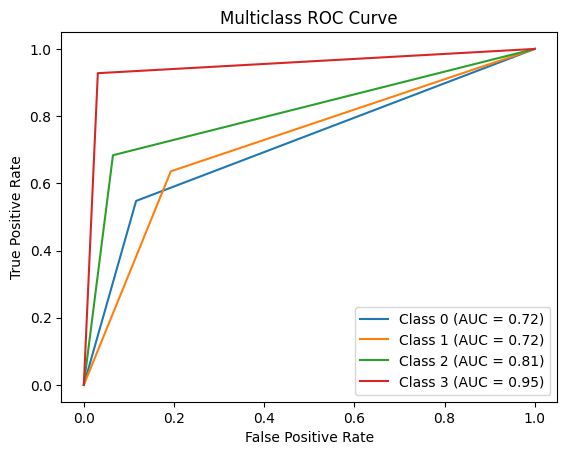

In [72]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # Predict probabilities for the first 5 samples in the validation set
    probs = model.predict_proba(X_val[:5])
    print(probs)


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(model, X_val, y_val)


## Artificial Neural Network

Training improved neural network...
Training completed!
Number of iterations: 105
Final loss: 0.3777

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.8042704626334519
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       336
           1       0.72      0.72      0.72       420
           2       0.83      0.77      0.80       275
           3       0.96      0.96      0.96       374

    accuracy                           0.80      1405
   macro avg       0.81      0.80      0.81      1405
weighted avg       0.81      0.80      0.80      1405

Cross-validation scores: [0.77224199 0.79715302 0.76512456 0.74733096 0.78647687]
Mean accuracy: 0.7736654804270463


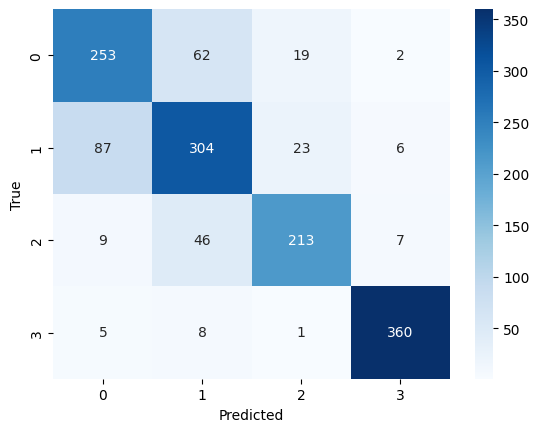

[[2.89161048e-01 1.15509541e-02 6.97782142e-01 1.50585634e-03]
 [7.69030296e-08 2.80494551e-07 7.92659054e-07 9.99998850e-01]
 [7.69803394e-02 1.05970456e-04 9.17649287e-01 5.26440340e-03]
 [8.28637035e-10 4.71033718e-07 3.80103638e-08 9.99999490e-01]
 [2.18712728e-02 1.73261085e-02 9.60760362e-01 4.22563378e-05]]


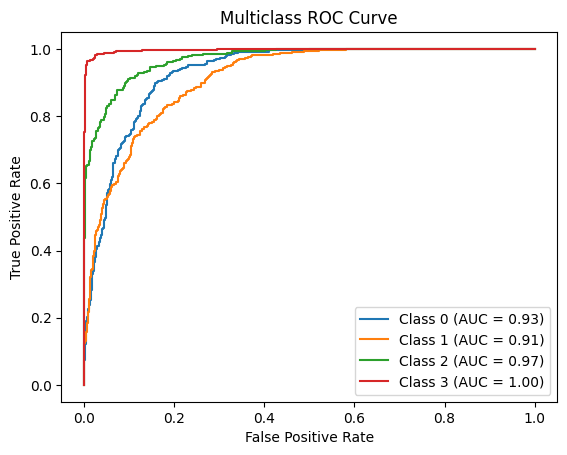

In [73]:
from sklearn.neural_network import MLPClassifier

def create_mlp_model(hidden_layer_sizes, activation, alpha, learning_rate_init):
    return MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver='adam',
        alpha=alpha,                                    # L2 regularization
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        validation_fraction=0.2,                        # Use 20% of training data for validation
        early_stopping=True,                            # Stop when validation score stops improving
        n_iter_no_change=50,                            # Stop after 50 iterations without improvement
        random_state=42,
        batch_size='auto'
    )

mlp = create_mlp_model(
    hidden_layer_sizes=(32, 16),
    activation='relu',
    alpha=0.001,
    learning_rate_init=0.001,
)

print("Training improved neural network...")
mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(mlp, X_val, y_val)

## Hyperparameter optimization

[I 2025-08-19 15:21:30,603] A new study created in memory with name: no-name-e185e2ef-1954-4360-a9b1-1117eabe532c
[I 2025-08-19 15:21:36,021] Trial 0 finished with value: 0.8013113754193352 and parameters: {'hidden_layer_sizes': '128-64', 'activation': 'tanh', 'alpha': 0.0008298953410821029, 'learning_rate_init': 0.005797968649275345}. Best is trial 0 with value: 0.8013113754193352.
[I 2025-08-19 15:21:38,203] Trial 1 finished with value: 0.8002439768222018 and parameters: {'hidden_layer_sizes': '64-32', 'activation': 'tanh', 'alpha': 0.00023369528795820496, 'learning_rate_init': 0.016485494428444502}. Best is trial 0 with value: 0.8013113754193352.
[I 2025-08-19 15:21:41,137] Trial 2 finished with value: 0.8055809698078682 and parameters: {'hidden_layer_sizes': '128-64', 'activation': 'relu', 'alpha': 0.09053976430954042, 'learning_rate_init': 0.004143116910972577}. Best is trial 2 with value: 0.8055809698078682.
[I 2025-08-19 15:21:43,452] Trial 3 finished with value: 0.7994815492528

Top 5 trials:
        value params_hidden_layer_sizes params_activation  params_alpha  \
12  0.810765                        32              relu      0.000736   
9   0.808326                        32              relu      0.000415   
8   0.808021                        32              relu      0.000359   
4   0.806191                    128-64              tanh      0.097916   
2   0.805581                    128-64              relu      0.090540   

    params_learning_rate_init  
12                   0.025468  
9                    0.004731  
8                    0.020123  
4                    0.003606  
2                    0.004143  


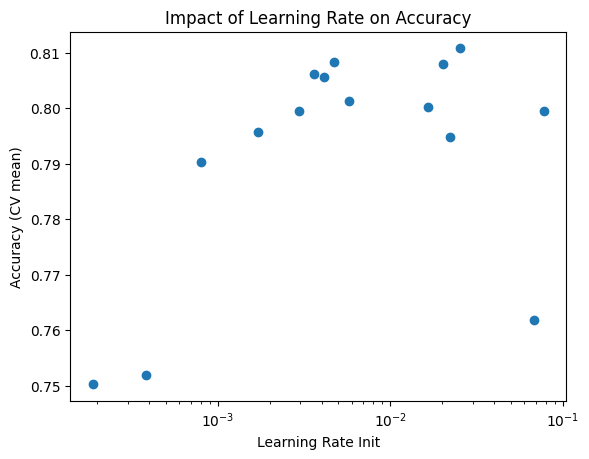

In [74]:
import optuna

def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['32', '64', '64-32', '128-64'])
    layer_map = {
        '32': (32,),
        '64': (64,),
        '64-32': (64, 32),
        '128-64': (128, 64)
    }
    hidden_layer_sizes = layer_map[hidden_layer_sizes]

    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=2000,
        early_stopping=True,
        random_state=42
    )

    scores = cross_val_score(mlp, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# -------------------------------
# 📊 Step 12.1 - Results Analysis
# -------------------------------
# Convert trials to a DataFrame
df_results = study.trials_dataframe()

# Sort by best accuracy
df_sorted = df_results.sort_values('value', ascending=False)
print("Top 5 trials:\n", df_sorted[['value', 'params_hidden_layer_sizes', 
                                    'params_activation', 'params_alpha', 
                                    'params_learning_rate_init']].head())

# -------------------------------
# 📈 Step 12.2 - Visualization
# -------------------------------
# Plot accuracy vs learning rate
plt.scatter(df_results['params_learning_rate_init'], df_results['value'])
plt.xscale('log')
plt.xlabel("Learning Rate Init")
plt.ylabel("Accuracy (CV mean)")
plt.title("Impact of Learning Rate on Accuracy")
plt.show()


Best parameters: {'hidden_layer_sizes': '32', 'activation': 'relu', 'alpha': 0.000735555611572761, 'learning_rate_init': 0.025468126957539812}
Training improved neural network...
Training completed!
Number of iterations: 117
Final loss: 0.3732

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.8021352313167259
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       336
           1       0.71      0.74      0.73       420
           2       0.81      0.81      0.81       275
           3       0.97      0.96      0.96       374

    accuracy                           0.80      1405
   macro avg       0.80      0.80      0.80      1405
weighted avg       0.80      0.80      0.80      1405

Cross-validation scores: [0.77580071 0.80071174 0.74021352 0.75088968 0.77935943]
Mean accuracy: 0.7693950177935943


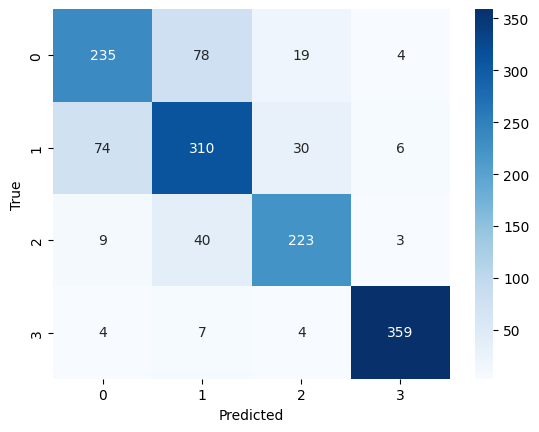

[[6.82206703e-01 2.18722098e-02 2.95921087e-01 3.47657689e-11]
 [1.47497755e-11 4.63250899e-12 9.46471493e-11 1.00000000e+00]
 [3.84281016e-04 1.88988446e-06 9.99613829e-01 4.02005165e-21]
 [2.28015176e-13 9.43109323e-11 1.57290204e-11 1.00000000e+00]
 [9.11121667e-03 1.68836367e-02 9.74005147e-01 2.96737618e-16]]


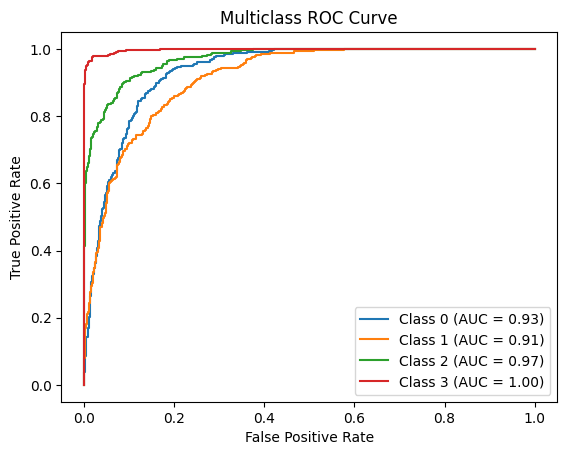


============== Test Accuracy: 0.8122332859174964 ==============
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       300
           1       0.73      0.74      0.73       431
           2       0.85      0.83      0.84       296
           3       0.99      0.96      0.97       379

    accuracy                           0.81      1406
   macro avg       0.81      0.81      0.81      1406
weighted avg       0.82      0.81      0.81      1406



In [75]:
# Train the best model on full training set
best_params = study.best_trial.params
print("Best parameters:", best_params)

layers = [int(x) for x in best_params['hidden_layer_sizes'].split('-')]
best_mlp = create_mlp_model(
    hidden_layer_sizes=layers,
    activation=best_params['activation'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
)

print("Training improved neural network...")
best_mlp.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {best_mlp.n_iter_}")
print(f"Final loss: {best_mlp.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(best_mlp, X_val, y_val)

# Evaluate on test set
y_pred = best_mlp.predict(X_test)
print("\n============== Test Accuracy:", accuracy_score(y_test, y_pred), "==============")
print(classification_report(y_test, y_pred))


### Model export

In [78]:
# train_export.py
import json
import os
import joblib
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from datetime import datetime

FEATURE_NAMES = emg_cols  # Use the original EMG column names
CLASS_NAMES = encoder.classes_.tolist()



df = pd.read_csv("data3.csv", sep=";")
df = df.drop_duplicates()  # remove duplicate rows
df = df.dropna() # remove rows with missing values



# Separate features and labels
X = df[emg_cols]

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())
Y = df['label']



X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", create_mlp_model(
        hidden_layer_sizes=layers,
        activation=best_params['activation'],
        alpha=best_params['alpha'],
        learning_rate_init=best_params['learning_rate_init'],
    ))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_eval)

metrics = {
    "accuracy": float(accuracy_score(y_eval, y_pred)),
    "report": classification_report(y_eval, y_pred, target_names=CLASS_NAMES, output_dict=True),
}

timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
model_dir = f"models/gesture_cls/1.0.0_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

# 1) Save pipeline
joblib.dump(pipe, f"{model_dir}/pipeline.joblib")

# 2) Save config (schema, classes, thresholds, etc.)
config = {
    "feature_names": FEATURE_NAMES,
    "class_names": CLASS_NAMES,
    "top_k": 2,
    "abstain_threshold": 0.6,  # below this max prob => "unknown"
    "random_state": 42,
    "library": {"sklearn": ">=1.2"},
}
with open(f"{model_dir}/config.json", "w") as f:
    json.dump(config, f, indent=2)

# 3) Save metrics
with open(f"{model_dir}/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Model exported to:", model_dir)



Encoded labels:
      label        gesture
0         2     wrist_back
1804      0           fist
4017      1          pinch
6927      3  wrist_forward
Model exported to: models/gesture_cls/1.0.0_20250819T132352Z
